In [2]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

Instructions for updating:
Use tf.gfile.GFile.
images/1.jpg


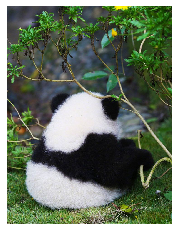

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca (score = 0.84371)
indri, indris, Indri indri, Indri brevicaudatus (score = 0.02797)
Walker hound, Walker foxhound (score = 0.00205)
teddy, teddy bear (score = 0.00183)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (score = 0.00136)

images/2.jpg


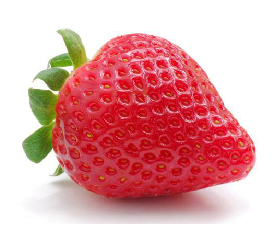

strawberry (score = 0.96860)
custard apple (score = 0.00069)
banana (score = 0.00051)
chocolate sauce, chocolate syrup (score = 0.00031)
trifle (score = 0.00030)

images/3.jpg


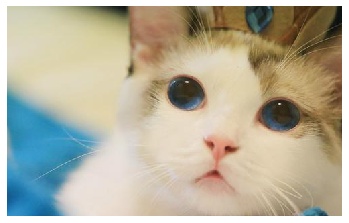

Egyptian cat (score = 0.21967)
Siamese cat, Siamese (score = 0.21553)
Angora, Angora rabbit (score = 0.04711)
tabby, tabby cat (score = 0.04486)
lynx, catamount (score = 0.03651)



In [3]:
class NodeLookup(object):
    def __init__(self):  
        # 文件样式 entry {  target_class: 449  target_class_string: "n01440764"} 表示有1000个分类
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'   
        # 文件样式 n00440218	jumping
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
    
    #分类编号与人类能读懂的分类名称关联
    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类编号字符串n********对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {} #字典
        #一行一行读取数据，存放在line中
        for line in proto_as_ascii_lines :
            #去掉换行符
            line=line.strip('\n')
            #按照'\t'分割
            parsed_items = line.split('\t')
            #获取分类编号字符串
            uid = parsed_items[0]
            #获取分类名称
            human_string = parsed_items[1]
            #保存分类编号字符串n********与分类名称映射关系 ，字典形式关联
            uid_to_human[uid] = human_string

        # 加载分类编号字符串n********对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {} #字典
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                #获取分类编号1-1000
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                #获取编号字符串n********
                target_class_string = line.split(': ')[1]
                #保存分类编号1-1000与编号字符串n********映射关系  字典形式关联 去掉双引号
                node_id_to_uid[target_class] = target_class_string[1:-2]

        #建立分类编号1-1000对应分类名称的映射关系
        #大概意思就是字典node_id_to_uid里面的val分类编号字符与uid_to_human里面的key分类编号字符相同时，
        #就能推理出node_id_to_uid里面的key分类编号与uid_to_human里面的value分类名称关联，组成新的字典node_id_to_name
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            #获取分类名称
            name = uid_to_human[val]
            #建立分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name
        return node_id_to_name

    #传入分类编号1-1000 ，就能返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

    
#读取训练好的Inception-v3模型来创建graph
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

#创建会话
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    #遍历目录，获取根目录image 子目录 无 文明
    for root,dirs,files in os.walk('images/'):
        for file in files:
            #载入图片（获取图片）
            image_data = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0': image_data})#图片格式是jpg格式
            predictions = np.squeeze(predictions)#把结果转为1维数据

            #打印图片路径及名称
            image_path = os.path.join(root,file)
            print(image_path)
            #显示图片
            img=Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            #排序 
            top_k = predictions.argsort()[-5:][::-1]  #将图片中概率从小到大排序，最后五个是最大概率，然后反序
            node_lookup = NodeLookup()  #类对象
            #反序后最大概率在最前面
            for node_id in top_k:     
                #获取分类名称分类名称的方法
                #NodeLookup中有通过node_id获取
                human_string = node_lookup.id_to_string(node_id)  
                #获取该分类的置信度,概率值 
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string, score))
            print()